# Lab Assignment 2 for CSE 7324 Fall 2017

___Members___: Hongning Yu, Hui Jiang, Hao Pan

## 1. Business Understanding
The dataset we use is a lyrics dataset (lyrics from MetrLyrics), which can be downloaded from Kaggle for free: https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics. By exploring this dataset, we are able to know the key features of certain song genre and predict the corresponding genre for new songs.
In this dataset, there are 362237 records and 5 features (song name, year, artist, genre, and lyrics). It is comprised of text documents and contains only text divided into documents. Besides, we can predict song genres according to lyrics. Obviously, it meets requirements for Lab 2.
For this project, our mainly purpose is to find the features for different song genres by analyzing the most frequent words in lyrics. And visualizing features will reveal more information about those features in the dataset. And then we may be able to figure out the relationship among features, which might benefit our genre prediction as well.
The statictic and prediction results can be applied to applications related to song searching or displaying. For example, song searching applications, like Siri may use when you ask her "What song is it?", can narrow down song searching scope by classify songs according to lyric features. As for song displaying application, it could reconmend songs by analyzing lyrics from users' favorite songs.
To ensure the correct rate of our prediction, we will keep a predict accuracy(AUC) target, like 80%, using accuracy measurement functions. We will use other more helpful evaluation metrics and functions if needed.
In [1]:


## 2. Data Encoding
First let's load the data in to dataframe. The data is already in a csv file but all of the lyrics are in raw text with different formats. Our gold is to predict genre basing on lyrics, so we still need to clean all lyrics.

In [1]:
import pandas as pd
import nltk
import numpy as np
import string

pd.set_option('display.max_columns', 60)

In [11]:
df = pd.read_csv("./lyrics.csv", encoding="utf-8")
df.head()

index             song  year           artist genre  \
0      0        ego-remix  2009  beyonce-knowles   Pop   
1      1     then-tell-me  2009  beyonce-knowles   Pop   
2      2          honesty  2009  beyonce-knowles   Pop   
3      3  you-are-my-rock  2009  beyonce-knowles   Pop   
4      4    black-culture  2009  beyonce-knowles   Pop   

                                              lyrics  
0  Oh baby, how you doing?\nYou know I'm gonna cu...  
1  playin' everything so easy,\nit's like you see...  
2  If you search\nFor tenderness\nIt isn't hard t...  
3  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...  
4  Party the people, the people the party it's po...

### check null values in dataset.

In [12]:
df.isnull().sum()

index         0
song          2
year          0
artist        0
genre         0
lyrics    95680
dtype: int64

Looks like there are null values in lyrics and song. Just drop them.

In [13]:
df.dropna(inplace=True)
df.isnull().sum()

index     0
song      0
year      0
artist    0
genre     0
lyrics    0
dtype: int64

### check genre

In [14]:
df.genre.value_counts()

Rock             109235
Pop               40466
Hip-Hop           24850
Not Available     23941
Metal             23759
Country           14387
Jazz               7970
Electronic         7966
Other              5189
R&B                3401
Indie              3149
Folk               2243
Name: genre, dtype: int64

As we can see, some genres have way more records than others. For our genre-predicting classification problem, we could sample the dataset and choose subsets of some genres to avoid bias. But let's now keep it as it is and deal with this later.

Check certain genres:

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266556 entries, 0 to 362236
Data columns (total 6 columns):
index     266556 non-null int64
song      266556 non-null object
year      266556 non-null int64
artist    266556 non-null object
genre     266556 non-null object
lyrics    266556 non-null object
dtypes: int64(2), object(4)
memory usage: 14.2+ MB


### 2.1 Read in data and check data quality

### Change to ASCII
First let's try to get rid of all non-ascii characters, since we only want english characters

**Takes too much time**

In [16]:
# %%time
# import re
# for row in df.index[:1000]:
#     df.loc[row, 'lyrics'] = df.loc[row, 'lyrics'].encode('ascii', errors='ignore').decode()

# for row in df.index[:1000]:
#     df.loc[row, 'lyrics'] = re.sub(r'[^\x00-\x7f]',
#                                    r'', 
#                                    df.loc[row, 'lyrics']) 

### English Filter
We want to focus on song's with english lyrics, so let's delete all non-english records if they exist.

I tried to build a English-ratio detector to eliminate all non-english songs. 
Reference: https://github.com/rasbt/musicmood/blob/master/code/collect_data/data_collection.ipynb

But the loop of set calculation **takes too much time**. Need to improve.

In [17]:
# %%time
# def eng_ratio(text):
#     ''' Returns the ratio of non-English to English words from a text '''

#     english_vocab = set(w.lower() for w in nltk.corpus.words.words()) 
#     text_vocab = set(w.lower() for w in text.split('-') if w.lower().isalpha()) 
#     unusual = text_vocab.difference(english_vocab)
#     diff = len(unusual)/(len(text_vocab)+1)
#     return diff

    
# # first let's eliminate non-english songs by their names
# before = df.shape[0]
# for row_id in range(100):
#     text = df.loc[row_id]['song']
#     diff = eng_ratio(text)
#     if diff >= 0.5:
#         df = df[df.index != row_id]
# after = df.shape[0]
# rem = before - after
# print('%s have been removed.' %rem)
# print('%s songs remain in the dataset.' %after)

### English Filter Ver.2
This is another approach, which uses a package from https://github.com/saffsd/langid.py. This package can detect language in a fairly quicker way. But still, 260k records takes around 50 mins.

In [18]:
%%time
# package from https://github.com/saffsd/langid.py
# import langid

# before = df.shape[0]
# for row in df.index:
#     lang = langid.classify(df.loc[row]['lyrics'])[0]
#     if lang != 'en':
#         df = df[df.index != row]
# after = df.shape[0]

# rem = before - after
# print('%s have been removed.' %rem)
# print('%s songs remain in the dataset.' %after)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


### save english songs to a new csv

In [19]:
df.to_csv('lyrics_new.csv',index_label='index')

*****
### Re-read csv file as df

In [2]:
df = pd.read_csv("./lyrics_new.csv", encoding="utf-8").drop('index.1', axis=1)
df.genre.value_counts()

Rock             109235
Pop               40466
Hip-Hop           24850
Not Available     23941
Metal             23759
Country           14387
Jazz               7970
Electronic         7966
Other              5189
R&B                3401
Indie              3149
Folk               2243
Name: genre, dtype: int64

### Resampling  df --> df_sample
300k records easily run out of memory. So I tried to resample the dataset and choose equal size of each genre.

In [3]:
grouped = df.groupby('genre')
df_sample = grouped.apply(lambda x: x.sample(n=1800, random_state=7))

print("Size of dataframe: {}".format(df_sample.shape[0]))
      
df_sample.genre.value_counts()

Size of dataframe: 21600


Pop              1800
Jazz             1800
Metal            1800
R&B              1800
Country          1800
Rock             1800
Hip-Hop          1800
Folk             1800
Other            1800
Indie            1800
Electronic       1800
Not Available    1800
Name: genre, dtype: int64

In [4]:
# reset index means remove index (and change index to a column if not drop)
df_sample.reset_index(drop=True, inplace=True)
df_sample.head(10)

index                            song  year          artist    genre  \
0   31180                  lover-s-return  2007  emmylou-harris  Country   
1   31978      riding-that-midnight-train  1993      doc-watson  Country   
2   29754             born-to-be-with-you  2007   bill-anderson  Country   
3  298315  nothing-compares-to-loving-you  2007    aaron-tippin  Country   
4  171110                   when-it-rains  2007  eli-young-band  Country   
5   32499          all-this-precious-time  2009   brett-perkins  Country   
6  146317                          wanted  2010    alan-jackson  Country   
7  131189            the-old-rugged-cross  2015    brad-paisley  Country   
8  298906                     human-thing  2008  be-good-tanyas  Country   
9  169032        so-da-voce-na-minha-vida  2015          daniel  Country   

                                              lyrics  
0  And so you have come back to me and say the ol...  
1  No matter what I say or do\nYou're never satis...  
2  BORN TO BE WITH YOU\n(Don Robertson)\n'62 Hill...  
3  Of all the things I've ever done\nI'd be hard ...  
4  I've me skies of black and blue, the way you m...  
5  You know I never meant to hurt you\nNever mean...  
6  Excuse me, ma'am can you help me\nI need to pl...  
7  On a hill far away, stood an old rugged Cross\...  
8  Yer a human thing\nWho yah think that you're f...  
9  Hoje cedo eu chorei\nAcordei com vocÃª na cabe...

### Check the lyrics' quality

In [5]:
# check lyrics with length less than 20
less_than_100 = 0
for row in df_sample.index[:1000]:
    if len(df_sample.loc[row]['lyrics'])<=100:
        print(df_sample.loc[row]['lyrics'])
        less_than_100 += 1
print("Num of lyrics with length less than 100 in first 1000: {}".format(less_than_100))

INSTRUMENTAL
you didn't know I wasn't free when you fell in love with me...
This track is an instrumental and has no lyrics.
Instrumental - there are no lyrics to this song
INSTRUMENTAL
INSTRUMENTAL
INSTRUMENTAL
INSTRUMENTAL
Num of lyrics with length less than 100 in first 1000: 8


### df_sample --> df_clean
It looks like lots of songs don't have meaningful lyrics(instrumental music, or something wrong happened when crawling).

So we just drop all song records with less than 100 lyric length

In [6]:
print("Deleting records with lyric length < 100")

len_before = df_sample.shape[0]

df_clean = df_sample.copy()

for row in df_clean.index:
    if len(df_clean.loc[row]['lyrics']) <= 100:
        df_clean.drop(row, inplace=True)

len_after = df_clean.shape[0]

print("Before: {}\nAfter : {}\nDeleted: {}".format(len_before, len_after, len_before-len_after))

Deleting records with lyric length < 100
Before: 21600
After : 20967
Deleted: 633


In [7]:
df_clean.genre.value_counts()

Pop              1790
R&B              1789
Country          1788
Other            1786
Hip-Hop          1778
Indie            1768
Jazz             1762
Rock             1750
Metal            1714
Electronic       1688
Not Available    1684
Folk             1670
Name: genre, dtype: int64

***
### transfer lyrics to list  
### df_clean -->x&y

In [8]:
x = df_clean['lyrics'].values
y = df_clean['genre'].values
print('Size of x: {}\nSize of y: {}'.format(x.size, y.size))

x = x.tolist()

x[1]

Size of x: 20967
Size of y: 20967


"No matter what I say or do\nYou're never satisfied\nI've tried to please you too many times\nSo now I'm leaving you now goodbye\nRiding on that midnight train\nLord my head's a hanging low\nThese awful blues will follow me\nWherever I may go\nWhy on earth was I ever born\nI'll never understand\nTo fall in love with a girl like you\nWho's in love with another man\nRiding on that midnight train\nLord my head's a hanging low\nThese awful blues will follow me\nWherever I may go\nYou broke a heart that trusted you\nWhy wasn't it made of stone\nYou've left my world as black as night\nAnd yet I must travel on\nRiding on that midnight train\nLord my head's a hanging low\nThese awful blues will follow me\nWherever I may go"

### removing puncturation and \n

#count average sentence length of each song before removing puncturations and newlines

reference: https://stackoverflow.com/questions/13970203/how-to-count-average-sentence-length-in-words-from-a-text-file-contains-100-se

In [9]:
# def count_sentence_len(lyric):
#     """count average sentence len for a lyric"""
#     sents_list = lyric.split('\n')
#     avg_len = sum(len(x.split()) for x in sents_list) / len(sents_list)
#     return avg_len

# sentence_length_avg = []

x_clean = []

translator = str.maketrans('', '', string.punctuation)
for l in x:
    l = l.translate(translator)
#     sentence_len = count_sentence_len(l)
#     sentence_length_avg.append(sentence_len)
    l = l.replace('\n', ' ')
    
    x_clean.append(l)

In [10]:
# randomly print 10 lyrics
import random
for i in random.sample(range(len(x_clean)), 10):
    print(x_clean[i])
    print("=============================")

Tonight could be just the beginning I should be smiling inside So Ill write a song that brings out the southern summers Just to share in a saving grace If I could find the words to say This wont hurt I promise you that If you feel me leave Im still here I see things all too clear When Im with you Picking up where we left off The last time we sailed across The sea was calm Setting sail and holding on To the best we can carry I count this one as a victory
I saw time turn so much there to unlearn You were envy you wouldnt say you tore heart strings That sorry day dark light hid the tears one for each of the years Love has reasons reason never knows Time turns over love overflows I should have spoken sooner On that sorry day your arms are open And I wondered why Wondered why Five years passed to the day time heals some people say When you hurt the ones I love youre also hurting me And time turns over turning you from me I thought youd never reach me On that sorry day your arms were open wi

In [29]:
print(len(x_clean))

20967


### 2.2 Removing stop words
nltk package has a build in library of stop words. Also when we transfering text to bag-of-words model, stop words can be eliminated automatically.

In [30]:
%%time
x_clean = [x.lower() for x in x_clean]

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
stop_words = list(ENGLISH_STOP_WORDS)
stop_words = stop_words + ['will', 'got', 'ill', 'im', 'let']

for text in x_clean:
    text = ' '.join([word for word in text.split() if word not in stop_words])

CPU times: user 17.5 s, sys: 23.5 ms, total: 17.5 s
Wall time: 17.5 s


### 2.3 Bag-of-words representation

Here I used a english dictionary from https://github.com/eclarson/MachineLearningNotebooks/tree/master/data

In [31]:
with open('./ospd.txt', encoding='utf-8', errors='ignore') as f1:
    vocab1 = f1.read().split("\n")

print(len(vocab1))

79340


In [32]:
from sklearn.feature_extraction.text import CountVectorizer



# CounterVectorizer can automatically change words into lower case
cv = CountVectorizer(stop_words='english',
                    encoding='utf-8',
                    lowercase=True,
                    vocabulary=vocab1)

bag_words = cv.fit_transform(x_clean)

print('Shape of bag words: {}'.format(bag_words.shape))
print("Length of Vocabulary: {}".format(len(cv.vocabulary_)))

Shape of bag words: (20967, 79340)
Length of Vocabulary: 79340


Let's createe a pandas dataframe containing bag-of-words(bow) model

In [33]:
df_bow = pd.DataFrame(data=bag_words.toarray(),columns=cv.get_feature_names())
df_bow

aa  aah  aahed  aahing  aahs  aal  aalii  aaliis  aals  aardvark  \
0       0    0      0       0     0    0      0       0     0         0   
1       0    0      0       0     0    0      0       0     0         0   
2       0    0      0       0     0    0      0       0     0         0   
3       0    0      0       0     0    0      0       0     0         0   
4       0    0      0       0     0    0      0       0     0         0   
5       0    0      0       0     0    0      0       0     0         0   
6       0    0      0       0     0    0      0       0     0         0   
7       0    0      0       0     0    0      0       0     0         0   
8       0    0      0       0     0    0      0       0     0         0   
9       0    0      0       0     0    0      0       0     0         0   
10      0    0      0       0     0    0      0       0     0         0   
11      0    0      0       0     0    0      0       0     0         0   
12      0    0      0       0     0    0      0       0     0         0   
13      0    0      0       0     0    0      0       0     0         0   
14      0    0      0       0     0    0      0       0     0         0   
15      0    0      0       0     0    0      0       0     0         0   
16      0    0      0       0     0    0      0       0     0         0   
17      0    0      0       0     0    0      0       0     0         0   
18      0    0      0       0     0    0      0       0     0         0   
19      0    0      0       0     0    0      0       0     0         0   
20      0    0      0       0     0    0      0       0     0         0   
21      0    0      0       0     0    0      0       0     0         0   
22      0    0      0       0     0    0      0       0     0         0   
23      0    0      0       0     0    0      0       0     0         0   
24      0    0      0       0     0    0      0       0     0         0   
25      0    0      0       0     0    0      0       0     0         0   
26      0    0      0       0     0    0      0       0     0         0   
27      0    0      0       0     0    0      0       0     0         0   
28      0    0      0       0     0    0      0       0     0         0   
29      0    0      0       0     0    0      0       0     0         0   
...    ..  ...    ...     ...   ...  ...    ...     ...   ...       ...   
20937   0    0      0       0     0    0      0       0     0         0   
20938   0    0      0       0     0    0      0       0     0         0   
20939   0    0      0       0     0    0      0       0     0         0   
20940   0    0      0       0     0    0      0       0     0         0   
20941   0    0      0       0     0    0      0       0     0         0   
20942   0    0      0       0     0    0      0       0     0         0   
20943   0    0      0       0     0    0      0       0     0         0   
20944   0    0      0       0     0    0      0       0     0         0   
20945   0    0      0       0     0    0      0       0     0         0   
20946   0    0      0       0     0    0      0       0     0         0   
20947   0    0      0       0     0    0      0       0     0         0   
20948   0    0      0       0     0    0      0       0     0         0   
20949   0    0      0       0     0    0      0       0     0         0   
20950   0    0      0       0     0    0      0       0     0         0   
20951   0    0      0       0     0    0      0       0     0         0   
20952   0    0      0       0     0    0      0       0     0         0   
20953   0    0      0       0     0    0      0       0     0         0   
20954   0    0      0       0     0    0      0       0     0         0   
20955   0    0      0       0     0    0      0       0     0         0   
20956   0    0      0       0     0    0      0       0     0         0   
20957   0    0      0       0     0    0      0       0     0         0   
20958   0    0      0       0   

In [34]:
%%time
word_freq = df_bow.sum().sort_values(ascending=False)

CPU times: user 1min 15s, sys: 9.97 s, total: 1min 25s
Wall time: 1min 32s


In [35]:
word_freq[:50]

love      28175
know      24464
like      24208
just      22566
oh        18084
got       17604
time      13872
baby      12873
come      12085
want      11875
let       11368
way       11108
say       11031
ill       10989
cause     10810
make      10468
yeah      10358
life       9145
la         8960
feel       8565
heart      8347
away       8151
right      8000
day        7772
tell       7691
need       7656
night      7587
man        7453
girl       6959
world      6771
good       6125
theres     6080
think      6042
little     6013
wont       5987
chorus     5632
eyes       5549
said       5438
long       5319
look       5112
mind       5091
home       4823
ya         4650
hold       4315
things     4194
gone       4104
better     3987
hear       3974
shit       3964
hey        3956
dtype: int64

### 2.4 Tf-idf representation

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(stop_words='english',
                             encoding='utf-8',
                             lowercase=True,
                             vocabulary=vocab1)

tfidf_mat = tfidf_vect.fit_transform(x_clean)

print('Shape of bag words: {}'.format(tfidf_mat.shape))
print("Length of Vocabulary: {}".format(len(tfidf_vect.vocabulary_)))

Shape of bag words: (20967, 79340)
Length of Vocabulary: 79340


In [37]:
df_tfidf = pd.DataFrame(data=tfidf_mat.toarray(),columns=tfidf_vect.get_feature_names())
df_tfidf

aa  aah  aahed  aahing  aahs  aal  aalii  aaliis  aals  aardvark  \
0      0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
1      0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
2      0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
3      0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
4      0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
5      0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
6      0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
7      0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
8      0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
9      0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
10     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
11     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
12     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
13     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
14     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
15     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
16     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
17     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
18     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
19     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
21     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
22     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
23     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
24     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
25     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
26     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
27     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
28     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
29     0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
...    ...  ...    ...     ...   ...  ...    ...     ...   ...       ...   
20937  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20938  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20939  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20940  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20941  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20942  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20943  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20944  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20945  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20946  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20947  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20948  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20949  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20950  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20951  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20952  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20953  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20954  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20955  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20956  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0   0.0       0.0   
20957  0.0  0.0    0.0     0.0   0.0  0.0    0.0     0.0

In [38]:
%%time
word_score = df_tfidf.sum().sort_values(ascending=False)

CPU times: user 1min 27s, sys: 10.9 s, total: 1min 37s
Wall time: 1min 50s


In [39]:
word_score[:100]

love       841.781959
know       651.681637
just       599.877895
like       580.089433
oh         527.711455
got        473.396914
time       449.033102
baby       449.009212
ill        416.830715
want       410.397613
come       393.501570
way        382.092720
let        377.206806
say        375.167945
heart      344.520442
life       343.706119
make       341.981948
cause      339.542503
la         329.942336
feel       324.650131
away       324.114457
yeah       309.969922
day        303.508018
night      299.223525
need       293.621530
tell       288.652384
world      281.973758
chorus     279.989384
right      276.438534
theres     263.445455
              ...    
face       158.578573
lost       158.336398
dream      156.368549
head       152.424459
going      152.258564
place      152.198087
really     151.177557
turn       150.812550
sun        150.491002
stop       149.263338
god        146.409595
end        143.376312
hand       142.278839
hard       141.977674
people    

## 3. Data Visualization
### 3.1 Summary
Let's use the original df for ploting.

In [40]:
df_clean.head()

index                            song  year          artist    genre  \
0   31180                  lover-s-return  2007  emmylou-harris  Country   
1   31978      riding-that-midnight-train  1993      doc-watson  Country   
2   29754             born-to-be-with-you  2007   bill-anderson  Country   
3  298315  nothing-compares-to-loving-you  2007    aaron-tippin  Country   
4  171110                   when-it-rains  2007  eli-young-band  Country   

                                              lyrics  
0  And so you have come back to me and say the ol...  
1  No matter what I say or do\nYou're never satis...  
2  BORN TO BE WITH YOU\n(Don Robertson)\n'62 Hill...  
3  Of all the things I've ever done\nI'd be hard ...  
4  I've me skies of black and blue, the way you m...

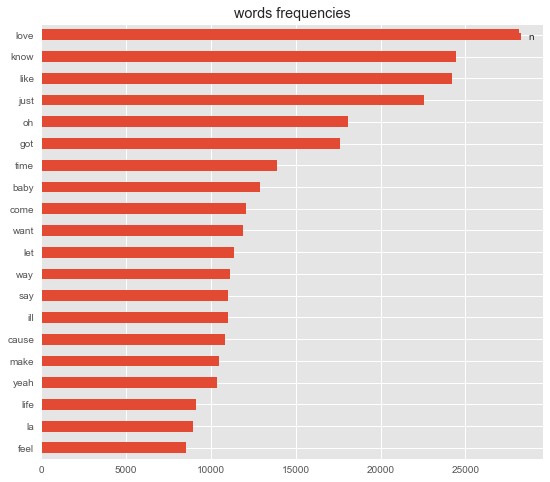

In [72]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

plt.style.use('ggplot')
freq = pd.DataFrame(word_freq, columns = ['frequency'])
freq[:20].plot(kind = 'barh', figsize=(9,8))
plt.legend('number of occurrences', loc = 'upper right')
plt.gca().invert_yaxis()
plt.title('words frequencies')

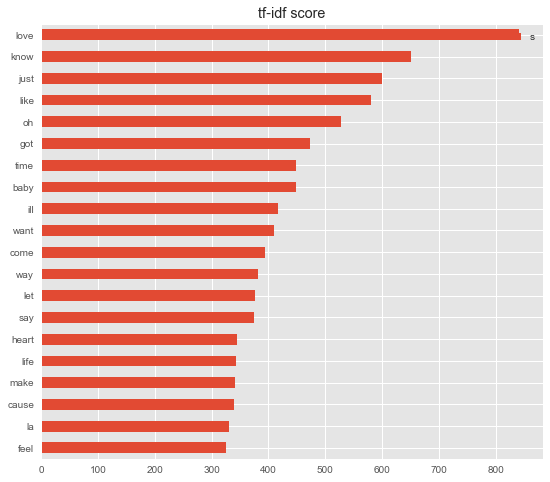

In [73]:
score = pd.DataFrame(word_score, columns = ['Score'])
ax = score[:20].plot(kind = 'barh', figsize=(9,8))
plt.legend('score', loc = 'upper right')
plt.gca().invert_yaxis()
plt.title('tf-idf score')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20967 entries, 0 to 21599
Data columns (total 7 columns):
index         20967 non-null int64
song          20967 non-null object
year          20967 non-null int64
artist        20967 non-null object
genre         20967 non-null object
lyrics        20967 non-null object
word_count    20967 non-null int64
dtypes: int64(3), object(4)
memory usage: 1.9+ MB


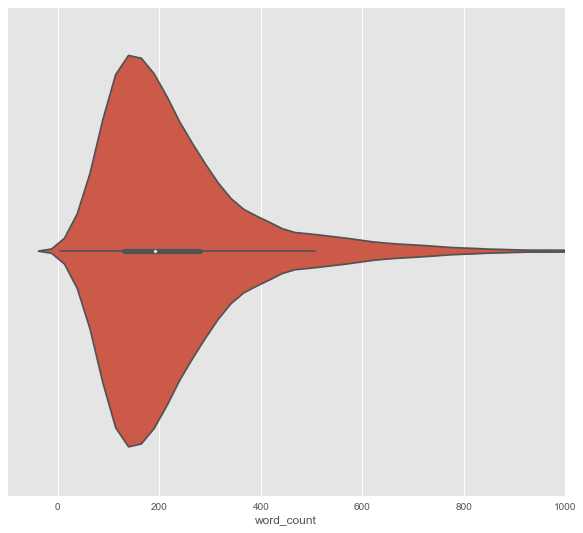

In [43]:
# code example from https://www.kaggle.com/carrie1/drug-of-choice-by-genre-using-song-lyrics
df_clean['word_count'] = df_clean['lyrics'].str.split().str.len()
df_clean.info()
f, ax = plt.subplots(figsize=(10, 9))
sns.violinplot(x = df_clean.word_count)
plt.xlim(-100, 1000)
plt.title('')

(1, 2000)

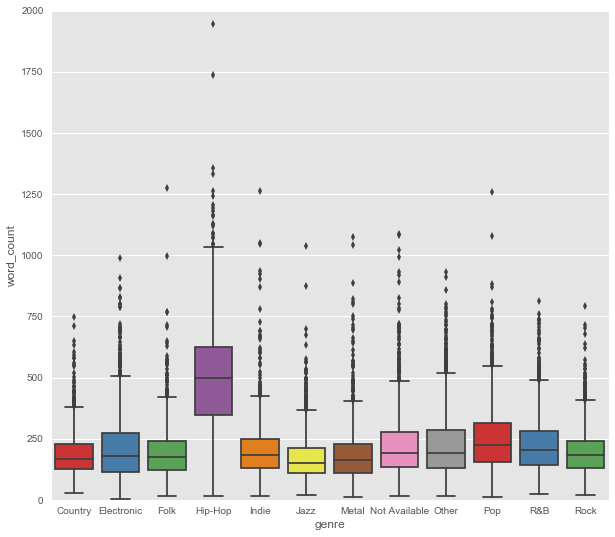

In [44]:
f, ax = plt.subplots(figsize=(10, 9))
sns.boxplot(x = "genre", y = "word_count", data = df_clean, palette = "Set1")
plt.ylim(1,2000)

Now let's draw some plots to show different genres from time perspective.

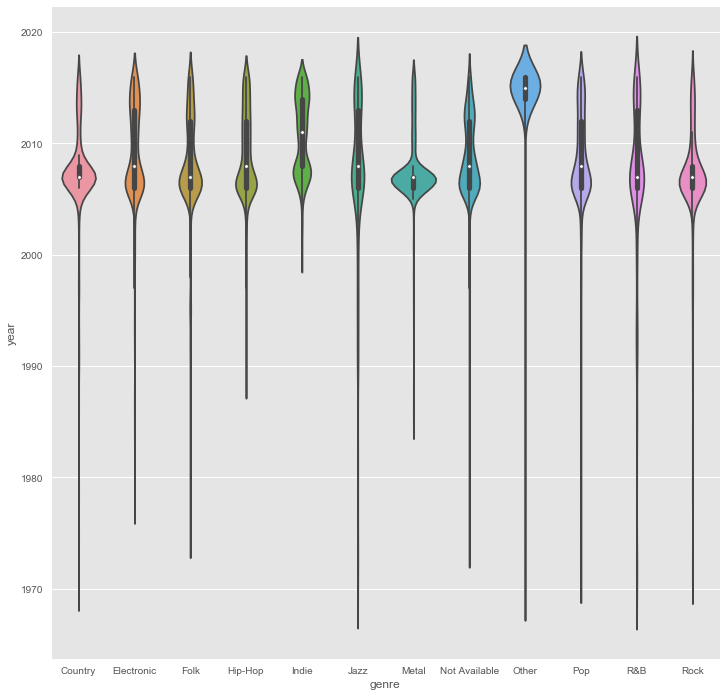

In [45]:
mpl.rc("figure", figsize=(12,12))
sns.violinplot(x='genre', y='year', data=df_clean)

In [46]:
df_clean[df_clean['year'] <= 2000].shape[0]

1008

In [47]:
for row in df_clean[df_clean['year'] <= 2000].index:
    df_clean.drop(row, inplace=True)

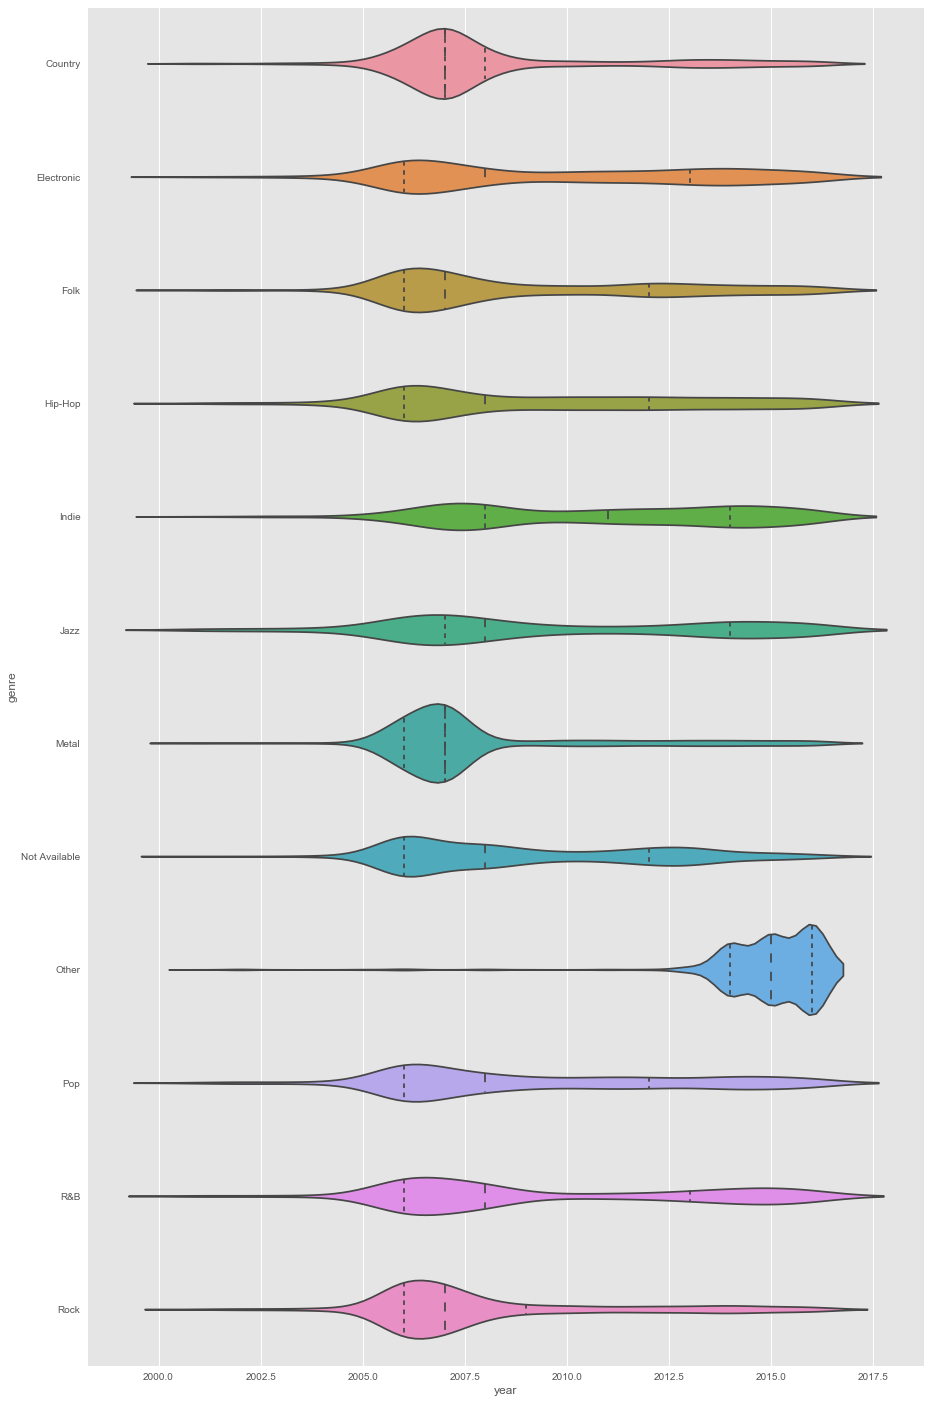

In [48]:
mpl.rc("figure", figsize=(15, 25))
sns.violinplot(x='year', y='genre', data=df_clean, inner="quartile")

In [49]:
top_artist = df.artist.value_counts().head(8).index.tolist()

# df_clean['artist'].isin(top_artist)
# df_clean.loc[df_clean['artist'] in]

df_top_artist = df_clean.loc[df_clean['artist'].isin(top_artist), :]
df_top_artist.head()

index                     song  year        artist    genre  \
39   67991    battle-of-new-orleans  2007   eddy-arnold  Country   
52  130064          i-knew-you-when  2008  dolly-parton  Country   
71  129740                   family  2006  dolly-parton  Country   
74   67733  carolina-in-the-morning  2007   eddy-arnold  Country   
76   68179           don-t-touch-me  2007   eddy-arnold  Country   

                                               lyrics  word_count  
39  In 1814, we took a little trip\nAlong with Col...         416  
52  That year the spring was six months long and l...         166  
71  (Dolly Parton/Carl Perkins)\nWhen it's family,...         255  
74  Nothing could be finer than to be in Carolina ...         114  
76  (Don't you touch me if you don't love me)\nYou...         126

In [50]:
df_top_artist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295 entries, 39 to 21469
Data columns (total 7 columns):
index         295 non-null int64
song          295 non-null object
year          295 non-null int64
artist        295 non-null object
genre         295 non-null object
lyrics        295 non-null object
word_count    295 non-null int64
dtypes: int64(3), object(4)
memory usage: 18.4+ KB


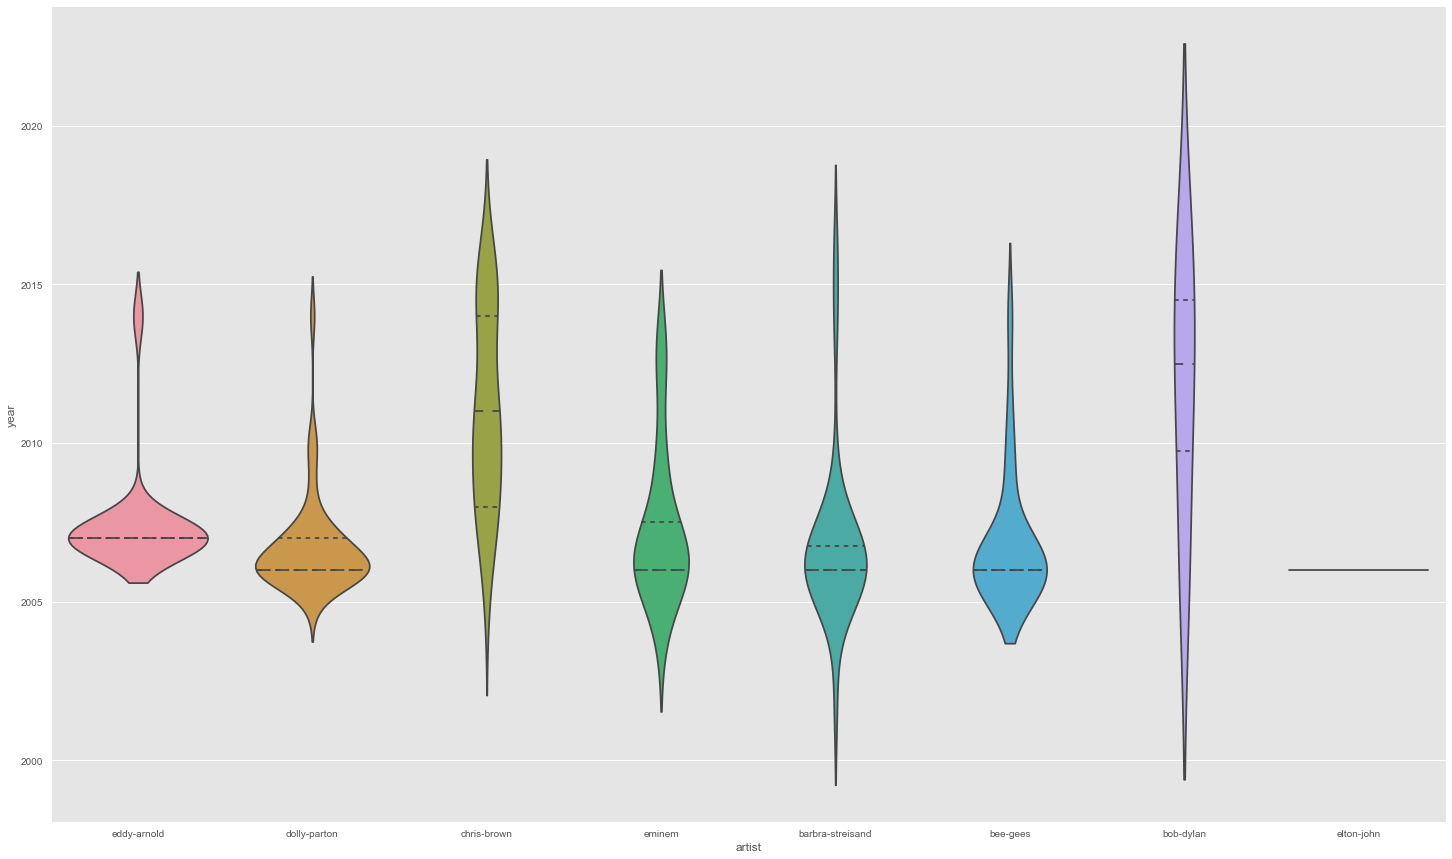

In [51]:
mpl.rc("figure", figsize=(25, 15))
sns.violinplot(x='artist', y='year', data=df_top_artist, inner="quartile")
sns.set(font_scale=2)

In [52]:
print(df_bow.shape)
print(len(y))

(20967, 79340)
20967


In [53]:
df_bow['length'] = df_bow.sum(axis=1)

In [54]:
# create two new columns: 
# @ length: length of documents basing on bag-of-word model
# @ genre: genre of the record

df_bow['genre'] = pd.Series(y).values

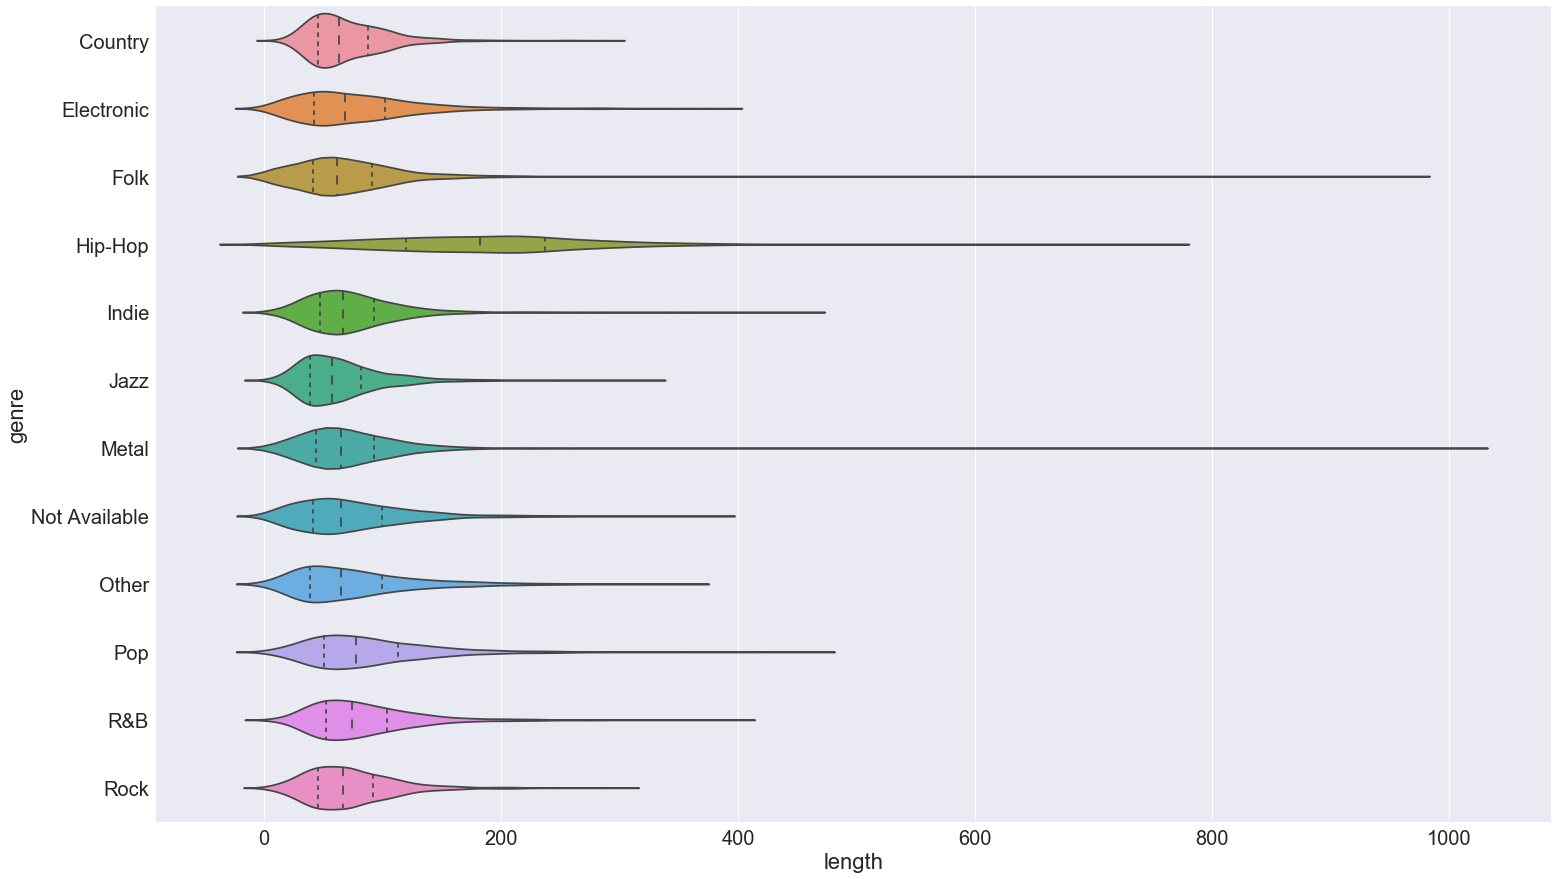

In [55]:
mpl.rc("figure", figsize=(25, 15))
sns.violinplot(x='length', y='genre', data=df_bow, inner="quartile")
sns.set(font_scale=3)

Next we want to check the top 10 frequent words of each genre.

In [56]:
genre_count = df_bow.groupby('genre').sum()
genre_count.drop('length', axis=1, inplace=True)
genre_count.head()

aa  aah  aahed  aahing  aahs  aal  aalii  aaliis  aals  aardvark  \
genre                                                                          
Country      0    0      0       0     0    0      0       0     0         0   
Electronic   0    4      0       0     0    0      0       0     0         0   
Folk         2    3      0       0     0    0      0       0     0         0   
Hip-Hop      0   16      0       0     0    0      0       0     0         0   
Indie        0   28      0       0     0    0      0       0     0         0   

            aardwolf  aargh  aarrgh  aarrghh  aas  aasvogel  aba  abaca  \
genre                                                                     
Country            0      0       0        0    0         0    0      0   
Electronic         0      0       0        0    0         0    0      0   
Folk               0      0       0        0    0         0    1      0   
Hip-Hop            0      0       0        0    0         0    0      0   
Indie              0      0       0        0    0         0    0      0   

            abacas  abaci  aback  abacus  abacuses  abaft  abaka  abakas  \
genre                                                                      
Country          0      0      0       0         0      0      0       0   
Electronic       0      0      0       1         0      0      0       0   
Folk             0      0      0       0         0      0      0       0   
Hip-Hop          0      0      0       0         0      0      0       0   
Indie            0      0      1       0         0      0      0       0   

            abalone  abalones  abamp  abampere ...  zygoid  zygoma  zygomas  \
genre                                          ...                            
Country           2         0      0         0 ...       0       0        0   
Electronic        0         0      0         0 ...       0       0        0   
Folk              0         0      0         0 ...       0       0        0   
Hip-Hop           0         0      0         0 ...       0       0        0   
Indie             0         0      0         0 ...       0       0        0   

            zygomata  zygose  zygoses  zygosis  zygosity  zygote  zygotene  \
genre                                                                        
Country            0       0        0        0         0       0         0   
Electronic         0       0        0        0         0       0         0   
Folk               0       0        0        0         0       0         0   
Hip-Hop            0       0        0        0         0       0         0   
Indie              0       0        0        0         0       0         0   

            zygotes  zygotic  zymase  zymases  zyme  zymes  zymogen  zymogene  \
genre                                                                           
Country           0        0       0        0     0      0        0         0   
Electronic        0        0       0        0     0      0        0         0   
Folk              0        0       0        0     0      0        0         0   
Hip-Hop           0        0       0        0     0      0        0         0   
Indie             0        0       0        0     0      0        0         0   

            zymogens  zymogram  zymology  zymosan  zymosans  zymoses  zymosis  \
genre                                                                           
Country            0         0         0        0         0        0        0   
Electronic         0         0         0        0         0        0        0   
Folk               0         0         0        0         0        0        0   
Hip-Hop            0         0         0        0         0        0        0   
Indie              0         0         0        0         0        0        0   

            zymotic  zymurgy  zyzzyva  zyzzyvas     
genre                                               
Country           0        0        0         0  

In [57]:
genre_count_new = genre_count.transpose()
genre_list = df_clean.genre.unique().tolist()

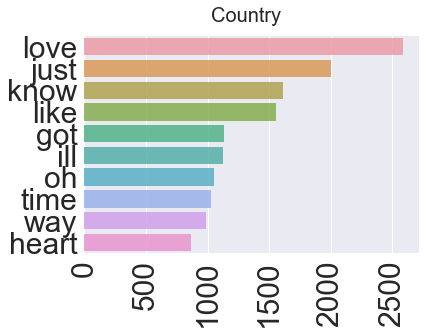

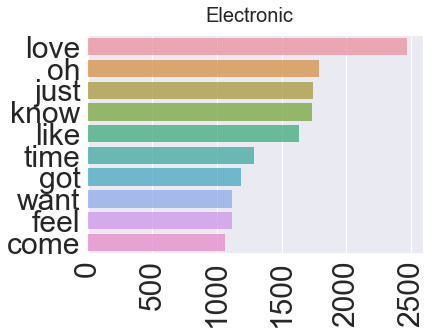

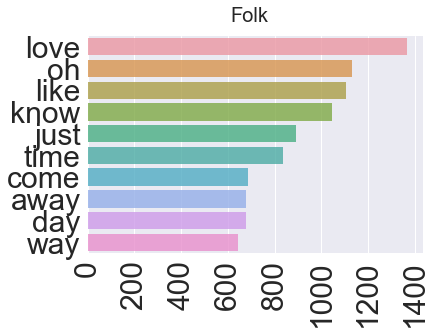

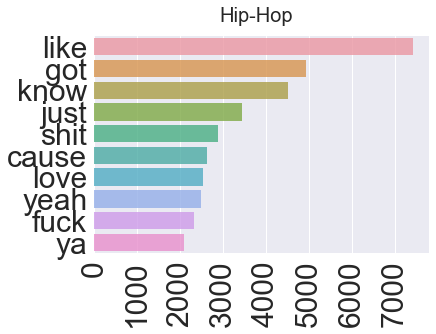

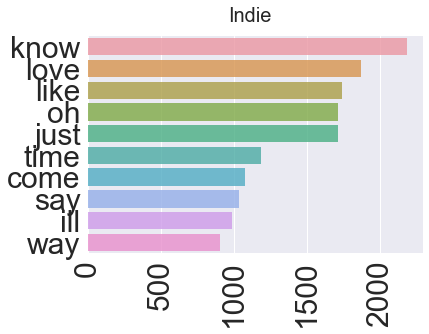

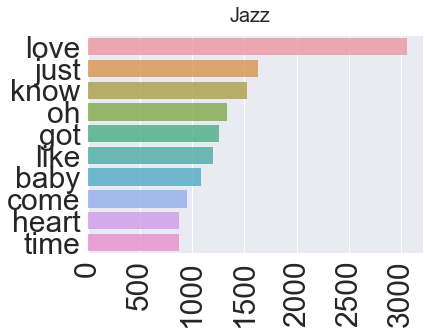

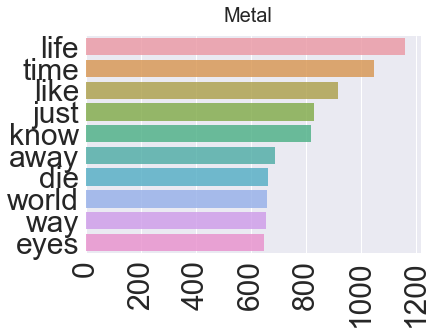

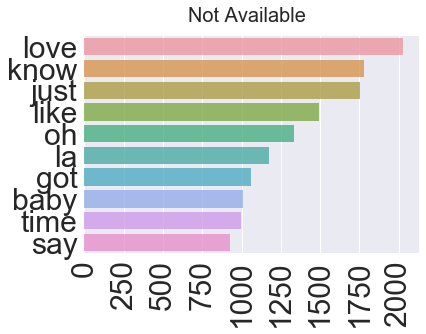

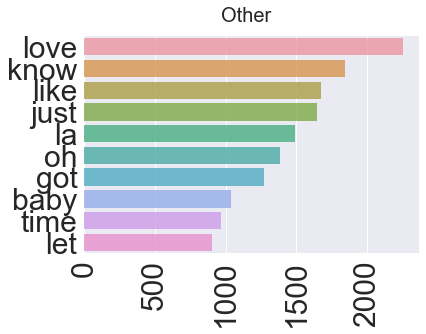

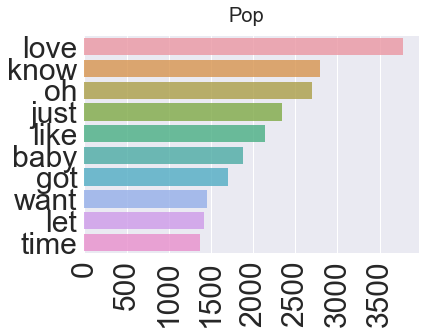

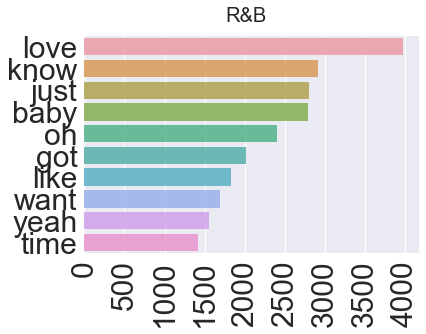

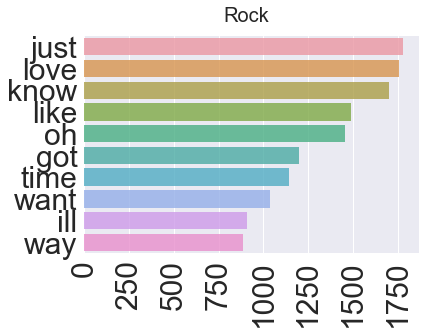

In [58]:
for genre in genre_list:
    t = genre_count_new.nlargest(10, genre, keep='first')[genre]
    
    fig = plt.figure(figsize=(6,4))
    fig.suptitle(genre, fontsize=20)
    plt.xticks(rotation='vertical')
    sns.barplot(t.values, t.index, alpha=0.8)
sns.set(font_scale=1)

From those histograms, it is pretty straightforward that 'love' is almost every types of music cared about. And also other words they share in common, which are 'know','time', 'oh' etc. And also many of those words are verbs.
We can take metal music for instance. A very interesting phenomenon is that word 'love' is out of the top 10 of metal music, instead of, 'die' shows up.
If you are esusipstic about metal music, you will probably get it. The idea is that there are different emotions behind the those different kinds of music. we can dig more into that and make out prediction better.

## 4. Word Cloud
Now it is 'wordcloud' time.
Word cloud is a visual representation of text data, and it is a very efficient way to represent word frequencies.
First let's try to draw and overall wordcloud basing on term frequency.

In [59]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
plt.style.use('ggplot')

all_lyrics = ''
for lyric in x_clean:
    all_lyrics += (' '+lyric)

(-0.5, 399.5, 199.5, -0.5)

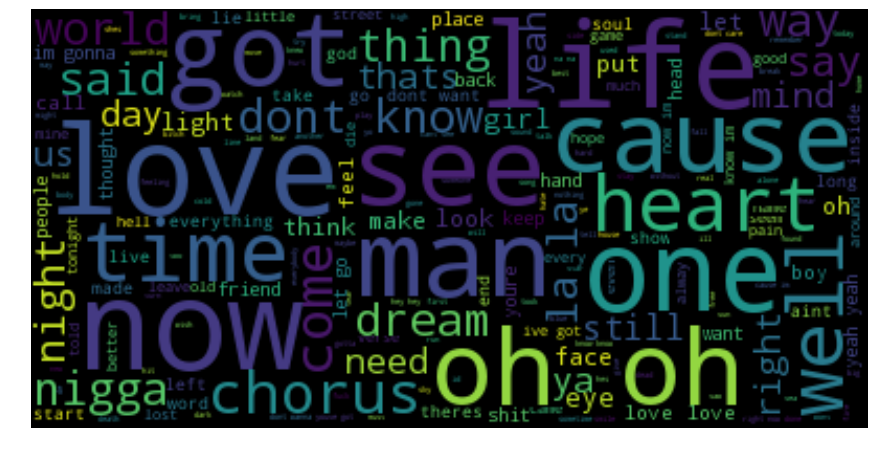

In [60]:
# code example from https://amueller.github.io/word_cloud/index.html
wordcloud = WordCloud(max_font_size=60).generate(all_lyrics)
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

We can clearly see that the most frequently used word is 'love' over all, then comes with 'got',

In [61]:
word_freq[:30]

love     28175
know     24464
like     24208
just     22566
oh       18084
got      17604
time     13872
baby     12873
come     12085
want     11875
let      11368
way      11108
say      11031
ill      10989
cause    10810
make     10468
yeah     10358
life      9145
la        8960
feel      8565
heart     8347
away      8151
right     8000
day       7772
tell      7691
need      7656
night     7587
man       7453
girl      6959
world     6771
dtype: int64

As we can see, the word cloud describes word frequency in a visuable way.

Let's try plot word clouds in different genres.

In [62]:
d = {'genre': y.tolist(), "lyric": x_clean}
df_plot = pd.DataFrame(d)
df_plot.head(10)

genre                                              lyric
0  Country  and so you have come back to me and say the ol...
1  Country  no matter what i say or do youre never satisfi...
2  Country  born to be with you don robertson 62 hill  ran...
3  Country  of all the things ive ever done id be hard pre...
4  Country  ive me skies of black and blue the way you mak...
5  Country  you know i never meant to hurt you never meant...
6  Country  excuse me maam can you help me i need to place...
7  Country  on a hill far away stood an old rugged cross t...
8  Country  yer a human thing who yah think that youre foo...
9  Country  hoje cedo eu chorei acordei com vocãª na cabeã...

Now let's separate those lyrics into different genres.

In [63]:
# create a dictionary and store all lyrics basing on their genre
lyrics = {}
for genre in df_plot.genre.unique().tolist():
    lyrics[genre] = ' '
    for row in (df_plot[df_plot['genre'] == genre].index):
        lyrics[genre] = lyrics[genre] + ' ' + df_plot.loc[row, 'lyric']

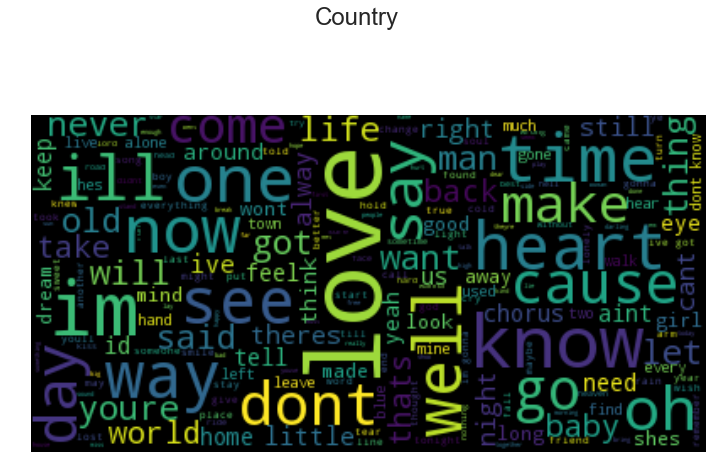

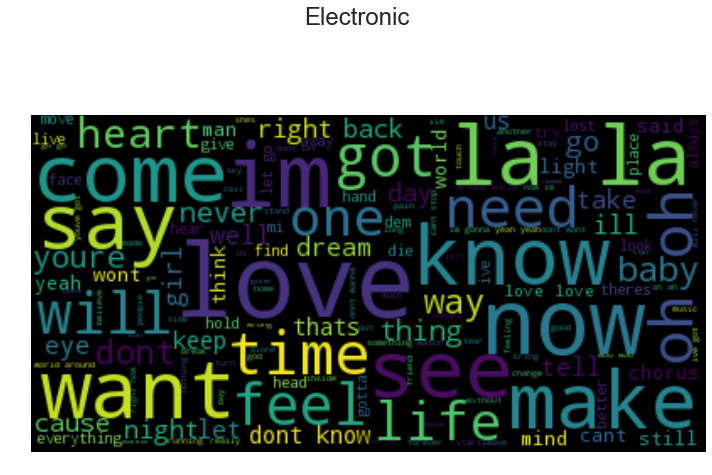

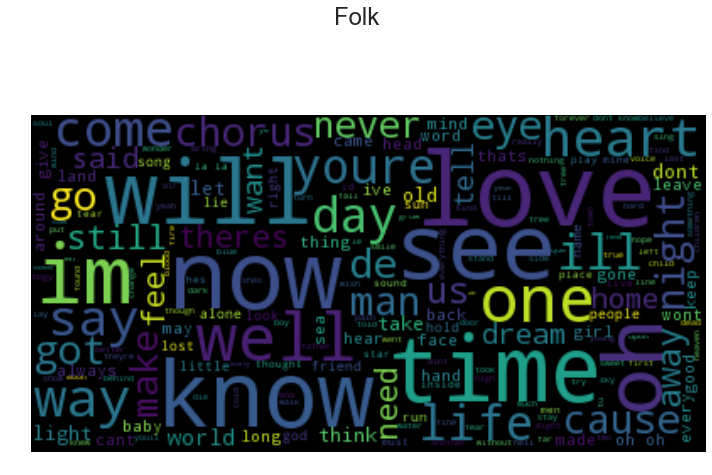

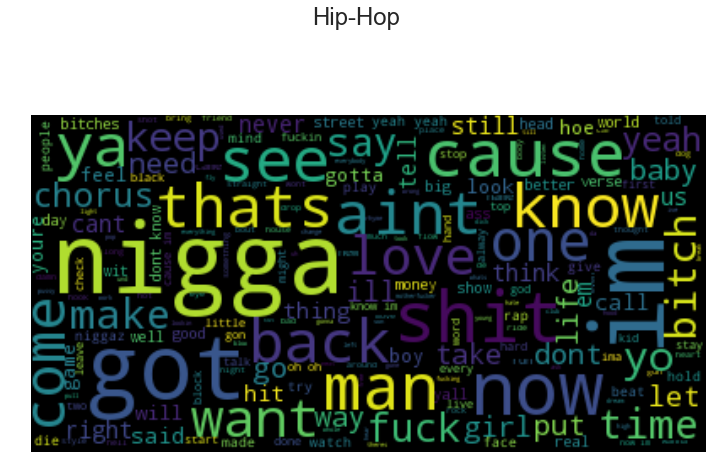

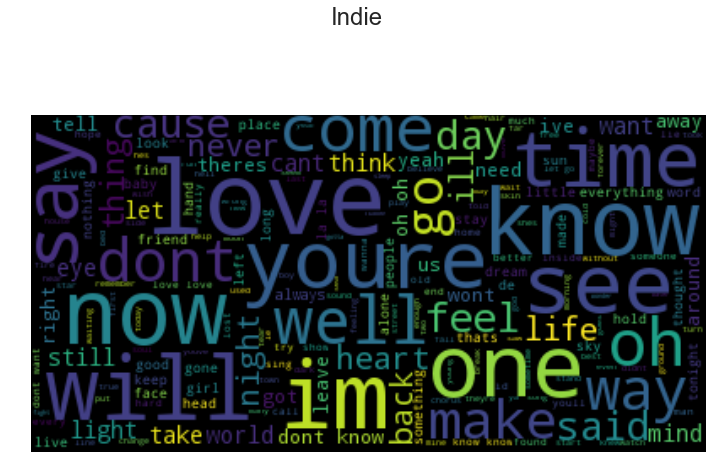

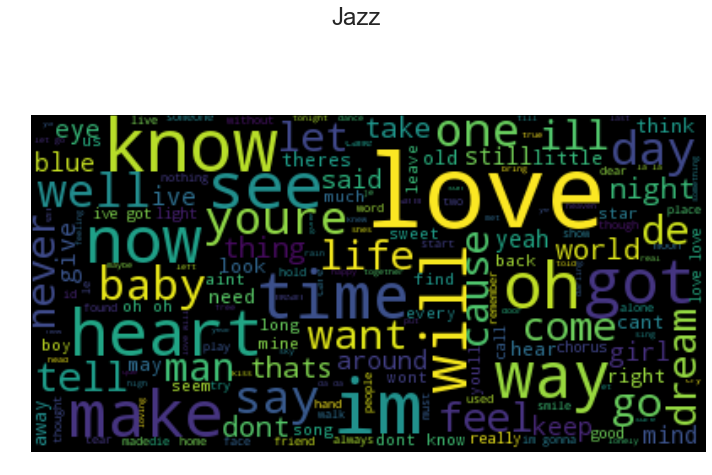

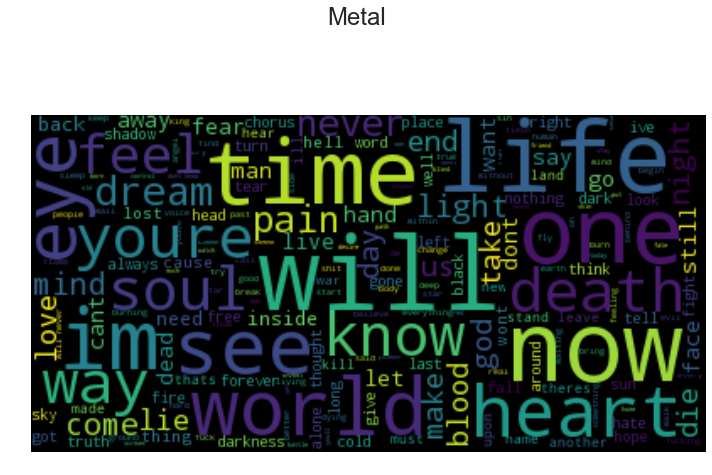

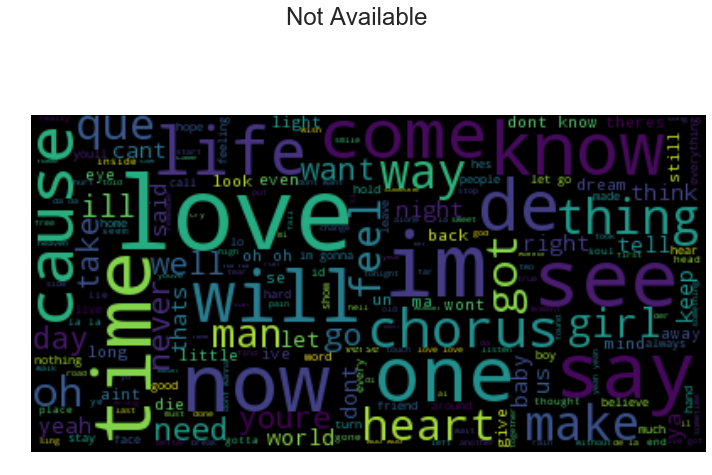

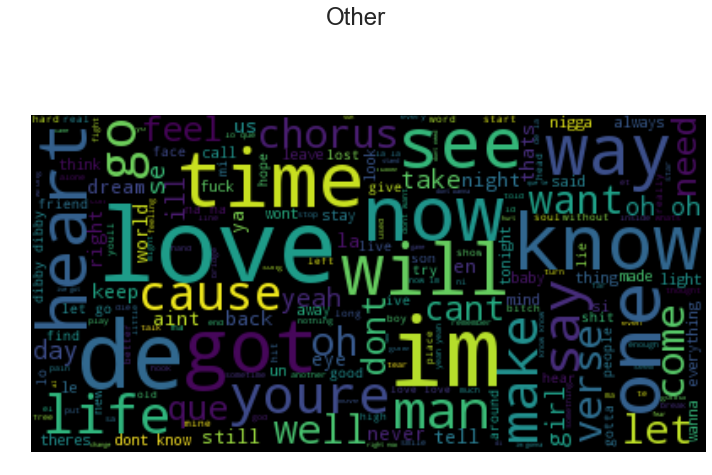

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [64]:
for genre, lyric in lyrics.items():
    wordcloud = WordCloud(max_font_size=60).generate(lyric)
    
    fig = plt.figure(figsize=(10,8))
    fig.suptitle(genre, fontsize=24)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout()

In thoes word cloud, word 'love' is almost the most frequent one in each genre. And word 'life', 'know' and 'time' etc. are frequently used as well.
But there are also some differences among those genres. For example, in jazz, word 'heart' used more that other genre,
and there are more dirty words in hip-hop, which makes sense.
After exploring all the lyrics, we can make a conclusion that most of the lyrics have some words in common, but depending on what kind of music they are, they do have unique words. Based on this results, we can make genre prediction in the future.